In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### No missing values

In [4]:
data['region'].value_counts().sort_values()

northeast    324
southwest    325
northwest    325
southeast    364
Name: region, dtype: int64

In [5]:
data['children'].value_counts().sort_values()

5     18
4     25
3    157
2    240
1    324
0    574
Name: children, dtype: int64

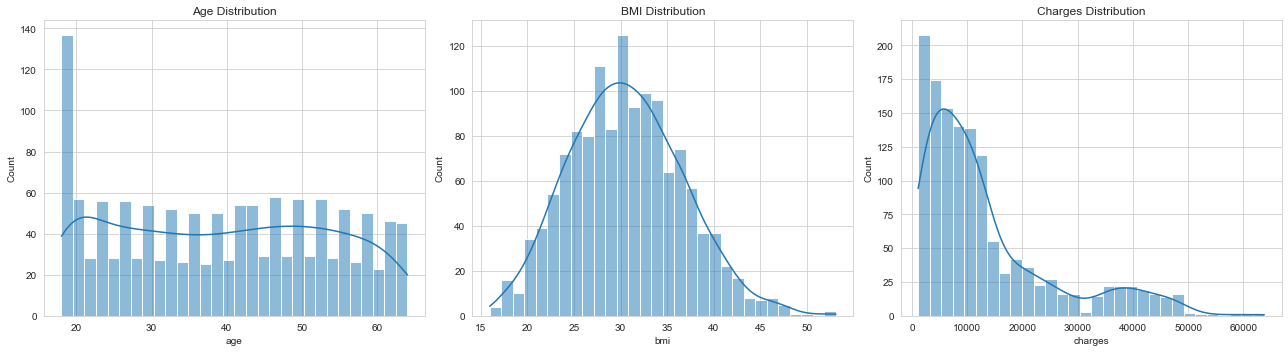

In [6]:
# Histograms for age, bmi and charges
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data['age'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Age Distribution')

sns.histplot(data['bmi'], bins=30, kde=True, ax=ax[1])
ax[1].set_title('BMI Distribution')

sns.histplot(data['charges'], bins=30, kde=True, ax=ax[2])
ax[2].set_title('Charges Distribution')

plt.tight_layout()

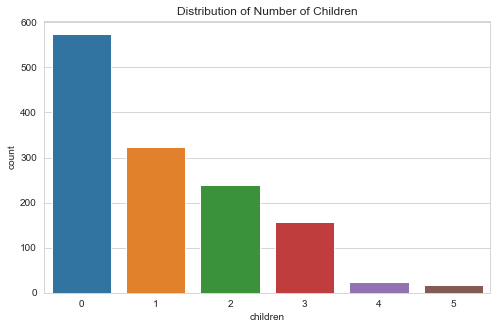

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x='children', data=data)
plt.title('Distribution of Number of Children')
plt.show()

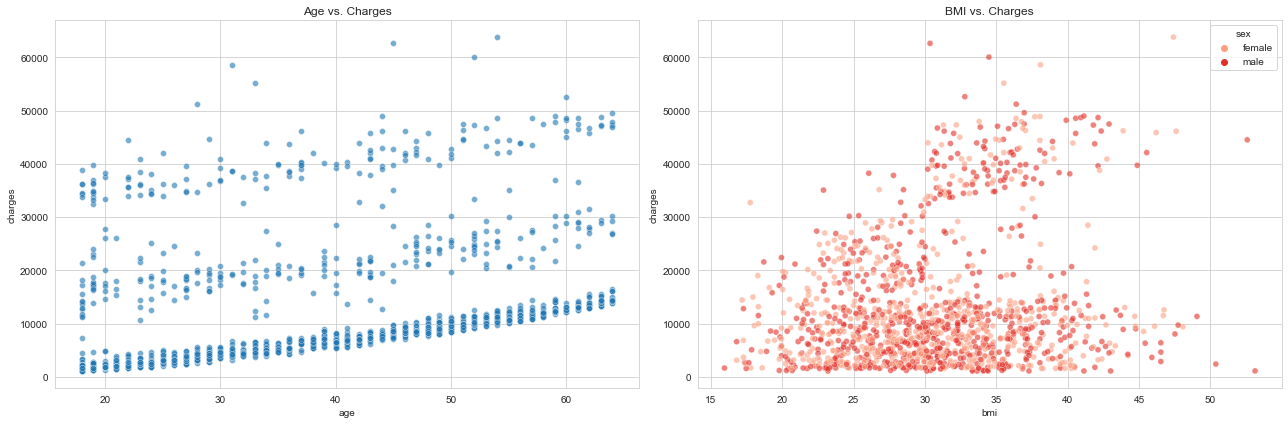

In [8]:
ig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot for age vs. charges
sns.scatterplot(x='age', y='charges', data=data, ax=ax[0], alpha=0.6)
ax[0].set_title('Age vs. Charges')

# Scatter plot for bmi vs. charges
sns.scatterplot(x='bmi', y='charges', data=data, ax=ax[1], alpha=0.6,hue='sex',palette='Reds')
ax[1].set_title('BMI vs. Charges')

plt.tight_layout()


#### There appears to be a positive correlation between age and insurance charges, with older individuals generally incurring higher charges. The plot also suggests three distinct groupings or "tiers" of charges, possibly reflecting different policy types or health statuses. Similar to the age vs. charges plot, there appears to be clustering, suggesting that factors other than BMI (such as smoking status or the presence of certain health conditions) also significantly impact charges.

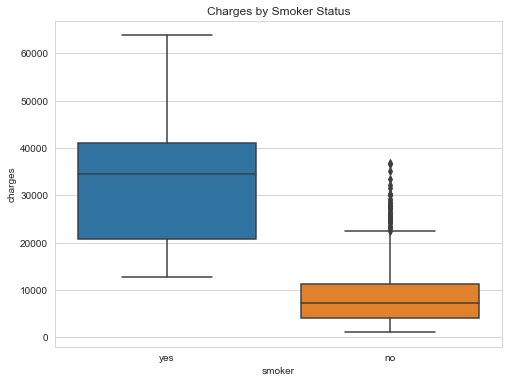

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Charges by Smoker Status')
plt.show()

#### There is a significant difference in insurance charges between smokers and non-smokers, with smokers facing significantly higher charges. This shows that smoking is a critical factor in determining insurance costs.

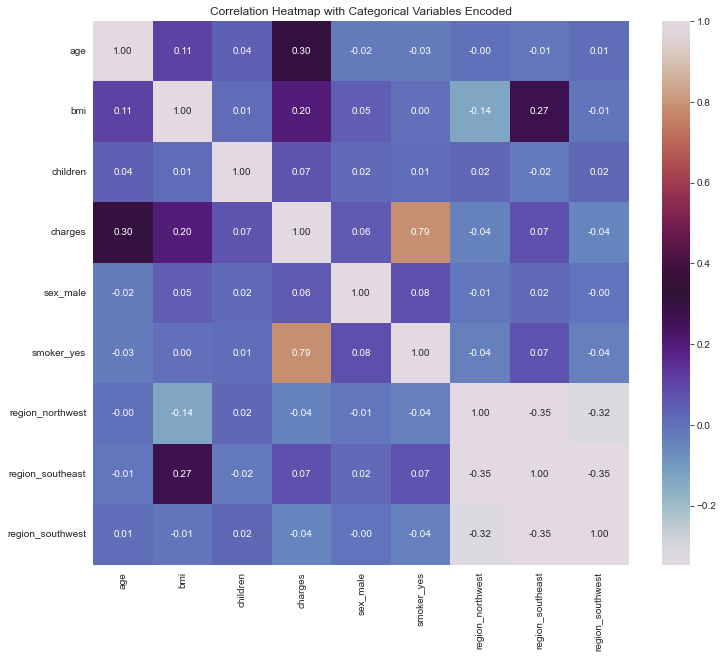

In [10]:
#one-hot encoding the variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Calculating the new correlation matrix
corr_matrix_encoded = data_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_encoded, annot=True, cmap='twilight', fmt=".2f")
plt.title('Correlation Heatmap with Categorical Variables Encoded')
plt.show()

#### Smoker, Age and BMI display positive correlation with charges. 




In [11]:
skewness=data.skew(numeric_only=True)
skewness

age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

#### The columns appear to be only moderately skewed. The skewness in the charges column suggests  that while most individuals incur relatively low costs, there's a significant subset with very high medical expenses. This could be due to a variety of factors, including chronic conditions, accidents, or other health issues that require expensive treatment.



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

categorical_columns = ['sex', 'smoker', 'region']
numeric_columns = ['age', 'bmi', 'children']

# Preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)])

# Creating a preprocessing and modeling pipeline
model_lr = make_pipeline(preprocessor, LinearRegression())

# Split the dataset
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Linear Regression model
model_lr.fit(X_train, y_train)

# Predicting on the test set
y_pred_lr = model_lr.predict(X_test)

# Evaluating the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}, R-squared: {r2_lr}")

Linear Regression MSE: 33596915.85136149, R-squared: 0.7835929767120722


In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


model_dt = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))

# Training the Decision Tree model
model_dt.fit(X_train, y_train)

# Predicting on the test set
y_pred_dt = model_dt.predict(X_test)

# Evaluating the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree MSE: {mse_dt}, R-squared: {r2_dt}")


Decision Tree MSE: 40795333.45408598, R-squared: 0.7372259788399772


In [14]:
from sklearn.ensemble import RandomForestRegressor


model_rf = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))

# Train the Random Forest model
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}, R-squared: {r2_rf}")


Random Forest MSE: 20864569.513376206, R-squared: 0.8656055394920775


In [15]:
from xgboost import XGBRegressor


model_xgb = make_pipeline(preprocessor, XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))

# Train the XGBoost model
model_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}, R-squared: {r2_xgb}")


XGBoost MSE: 23434704.61742758, R-squared: 0.8490505887407566


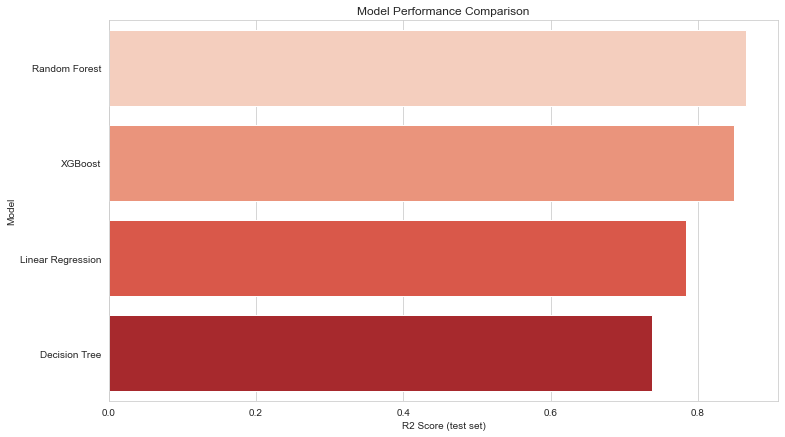

In [18]:
rmse_lr = np.sqrt(mse_lr)
rmse_dt = np.sqrt(mse_dt)
rmse_rf = np.sqrt(mse_rf)
rmse_xgb = np.sqrt(mse_xgb)

models_summary = [
    ('Linear Regression', rmse_lr, r2_lr),
    ('Decision Tree', rmse_dt, r2_dt),
    ('Random Forest', rmse_rf, r2_rf),
    ('XGBoost', rmse_xgb, r2_xgb)
]
models_df = pd.DataFrame(models_summary, columns=['Model', 'RMSE', 'R2_Score(test)'])
plt.figure(figsize=(12, 7))
models_df.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)
sns.barplot(x='R2_Score(test)', y='Model', data=models_df, palette='Reds')
plt.xlabel('R2 Score (test set)')
plt.ylabel('Model')
plt.title('Model Performance Comparison')
plt.show()

#### Since, Random Forest model is performing well, so let us deploy the Random Forest model within the streamlit app.

In [19]:
import pickle

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(model_rf, file)